In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import collections
import copy
import sys
sys.stdout.flush()

from processing_functions import *

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['mathtext.rm'] = 'serif'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
rcParams['axes.titlepad'] = 12

In [2]:
from concurrent.futures import ProcessPoolExecutor as Pool

### Calculate inverse covariance matrices by combination.

In [3]:
jkcov = np.load('Run_multidark_30/jk_21p0.npz')['jkcov']
fidreal = np.load('Run_multidark_30/fidreal_21p0.npz')['func']
fidrandom = np.load('Run_multidark_30/fidrandom_21p0.npy')

covtot = calc_covariance(jkcov,fidreal,fidrandom)
cov_cut = apply_to_dict(cov_clean,cut_by_func_2D(covtot))
nzidx_cut = apply_to_dict(cov_clean,cut_by_func_2D(covtot),return_idx=1)
invcov_cut = apply_to_dict(inv_cov,cov_cut,rcond=1e-4)

p0 = p21p0
oneside = oneside_ranges[4]

### Use one seed for smoothing test.

In [4]:
keylist = ['w','d','v','c','a','r','wd','wv','wc','wa','wr','dv','dc','da','dr','vc','va','vr','ca','cr','ar',\
        'wdv','wdc','wda','wdr','wvc','wva','wvr','wca','wcr','war','dvc','dva','dvr','dca','dcr','dar',\
         'vca','vcr','var','car','wdvc','wdva','wdvr','wdca','wdcr','wdar','wvca','wvcr','wvar','wcar',\
        'dvca','dvcr','dvar','dcar','vcar','wdvca','wdvcr','wdvar','wdcar','wvcar','dvcar','wdvcar']

In [5]:
pertfunc_eg = np.load('Run_multidark_30/pert_21p0_34289.npz')['func_all']
pertparam_eg = np.load('Run_multidark_30/pert_21p0_34289.npz')['param']
func_cut_eg = apply_to_dict(pert_clean,cut_by_func_1D(pertfunc_eg,axis=1),nzidx_cut)

In [6]:
def get_alphas(combkey):
    return iterated_alpha(func_cut_eg[combkey],invcov_cut[combkey],pertparam_eg,p0,oneside)

In [7]:
alphas_cut = {}

with Pool(55) as pool:
    for i, output_data in enumerate(pool.map(get_alphas, keylist)):
        alphas_cut[keylist[i]] = output_data

### Fnd posterior covariances.

In [10]:
locfit_cut = apply_to_dict(locfit_comb,func_cut_eg,alphas_cut,xs=pertparam_eg,x0s=p0)
fisher_cut = apply_to_dict(calc_fisher,locfit_cut,invcov_cut)
#postcov = apply_to_dict(np.linalg.inv,fisher_cut)

In [12]:
sigma_dict = apply_to_dict(calc_1sigma,fisher_cut)
sigma_list = []
for k in keylist:
    sigma_list.append(sigma_dict[k])
sigma_list = np.array(sigma_list)
for i,k1 in enumerate(keylist):
    for j,k2 in enumerate(keylist):
        if set(k1).issubset(k2):
            assert all(sigma_list[i]>=sigma_list[j])

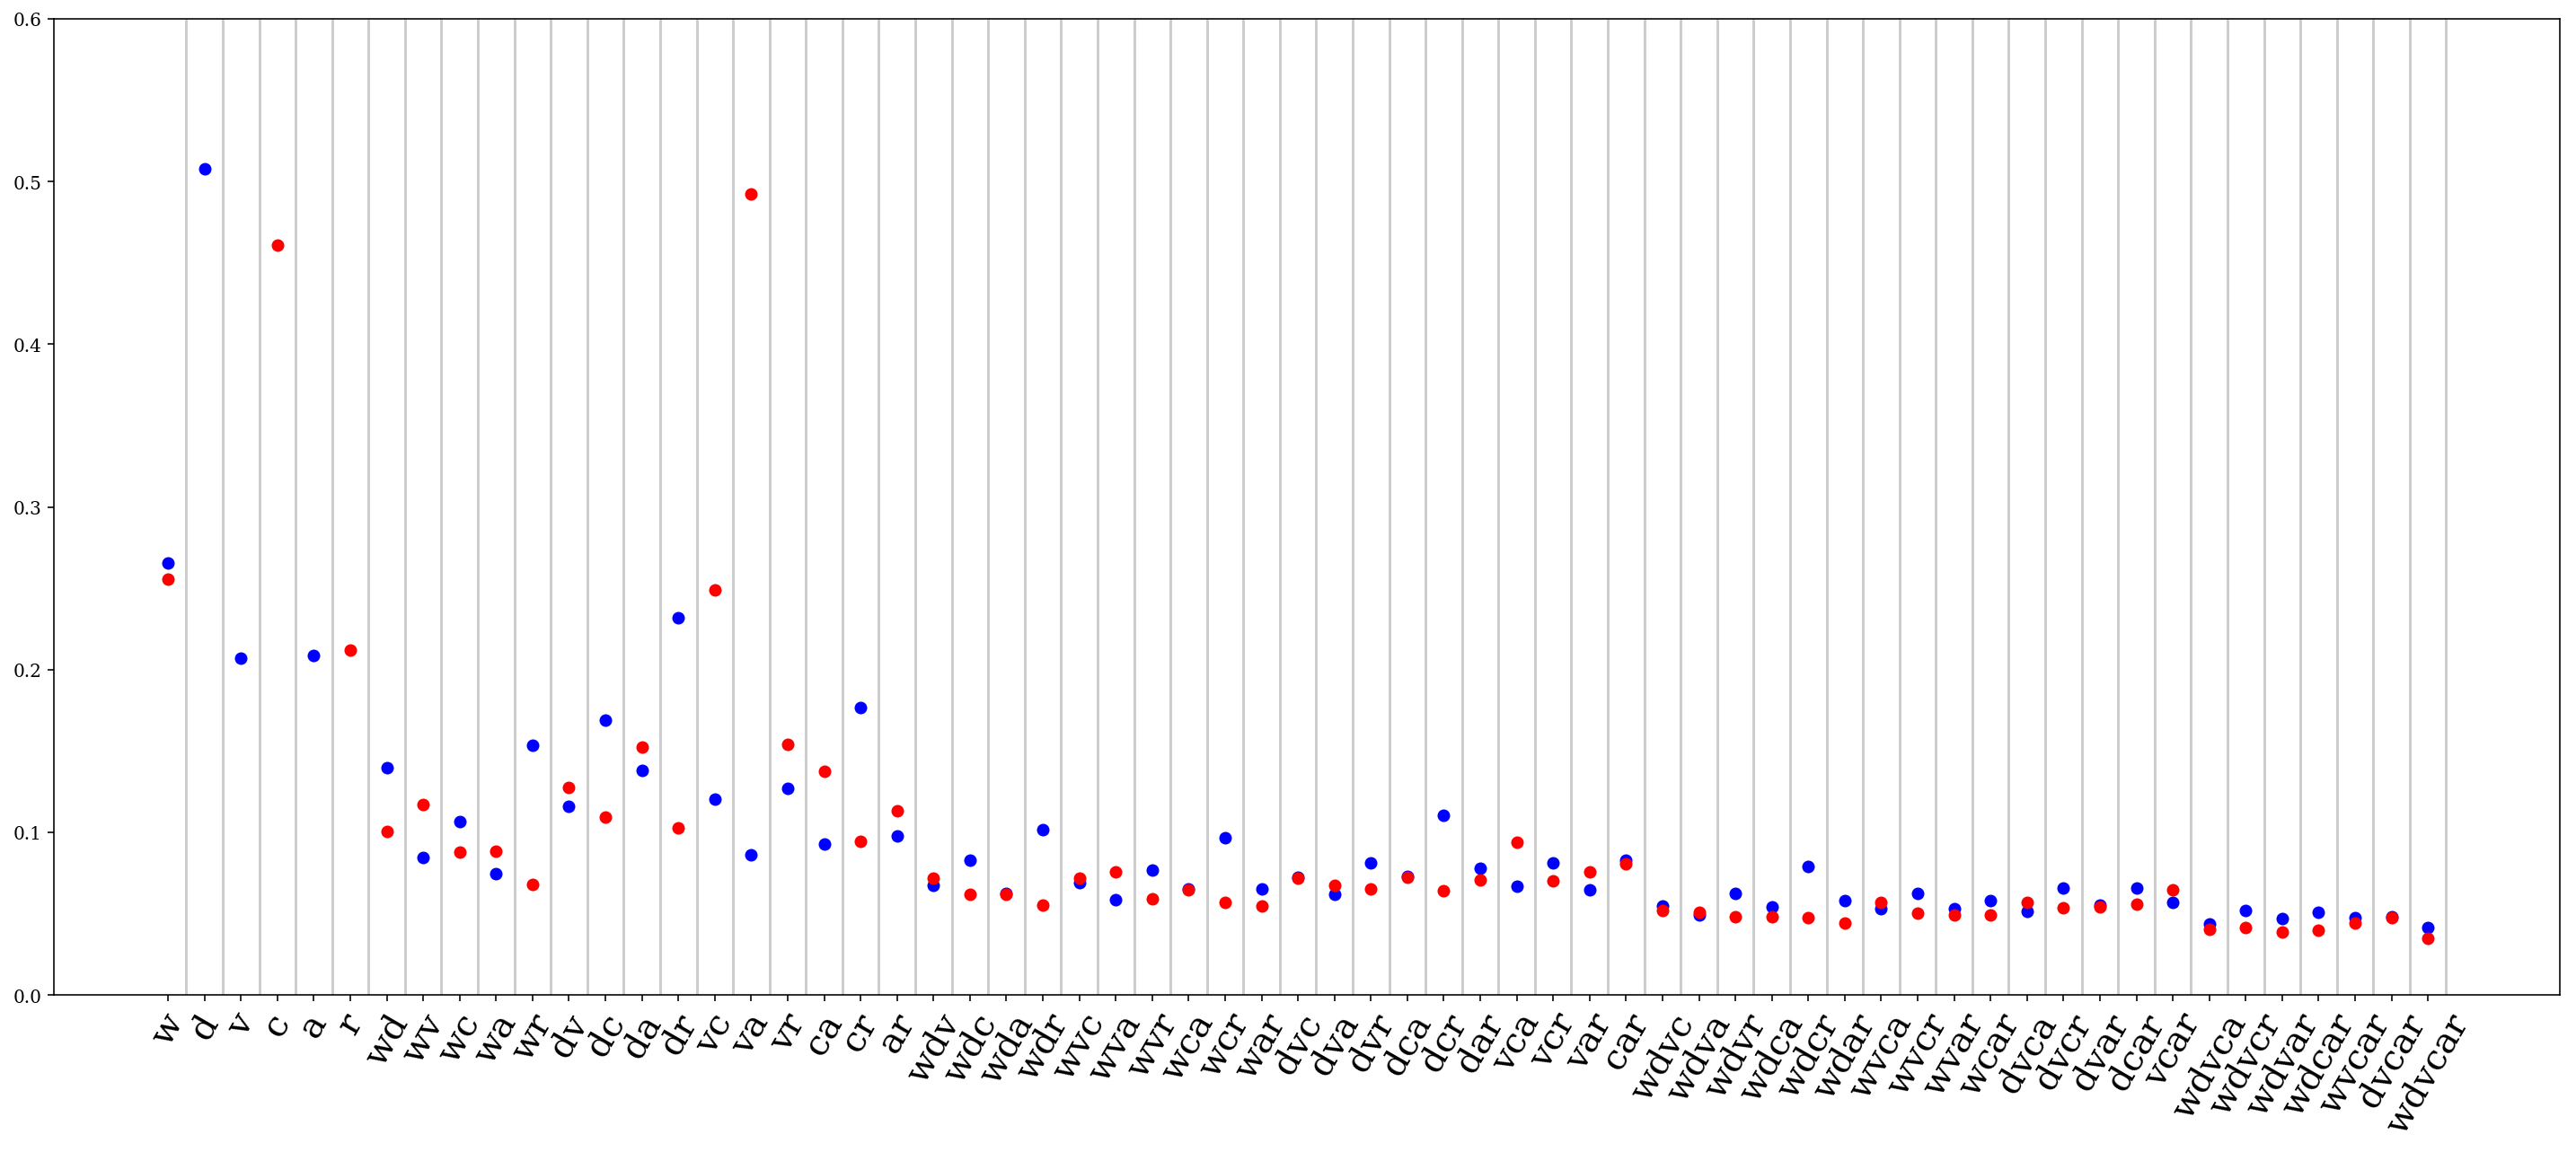

In [14]:
plt.figure(figsize=(25,10))
plt.plot(range(len(keylist)),sigma_list[:,5],'bo')
for i in range(len(keylist)):
    plt.axvline(i+0.5,c='k',alpha=0.1)
plt.xticks(range(len(keylist)),keylist,rotation=60,fontsize=20);
#plt.figure(figsize=(25,10))
plt.plot(range(len(keylist)),sigma_list[:,6],'ro')
for i in range(len(keylist)):
    plt.axvline(i+0.5,c='k',alpha=0.1)
plt.ylim(0,0.6)
plt.xticks(range(len(keylist)),keylist,rotation=60,fontsize=20);

In [17]:
zip(keylist,sigma_list)

[('w', array([ 0.03638348,  0.0173744 ,  0.17330948,  0.52972727,  0.02817955,
          0.26561811,  0.25572207])),
 ('d', array([ 0.19151721,  0.13282737,  0.25140327,  3.41988349,  0.1006098 ,
          0.5081367 ,  0.65186845])),
 ('v', array([ 0.57251541,  0.2240189 ,  0.17284455,  6.04159547,  0.06220192,
          0.20686416,  2.14688286])),
 ('c', array([ 0.03438982,  0.02379689,  0.34123422,  0.91960098,  0.07438291,
          0.7918256 ,  0.46104407])),
 ('a', array([ 0.05433472,  0.03544592,  0.17901669,  0.70659013,  0.01478357,
          0.20857104,  0.88187199])),
 ('r', array([ 0.16765165,  0.00725761,  0.06352382,  0.4903099 ,  0.04836996,
          2.63492325,  0.21227201])),
 ('wd', array([ 0.02097094,  0.009909  ,  0.0365341 ,  0.32476159,  0.00511404,
          0.13991204,  0.10056826])),
 ('wv', array([ 0.02025874,  0.00938691,  0.02952604,  0.31210262,  0.00643718,
          0.084682  ,  0.11734076])),
 ('wc', array([ 0.01025973,  0.00523726,  0.04192166,  0.19047